<a href="https://colab.research.google.com/github/darkxaze/Machinelearnning-courseworkprojects/blob/main/BloodMNISTCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random # for randomization

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports Functions & Libraries
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

All storage on a Google Colab instance is deleted when the instance ends so the dataset will need to be redownloaded each time an instance is created (Don't worry this usually takes about 20 seconds).

The dataset used in the current model is called Bloodmnist. All images are RGB and have 3 channels. The images are standardized and the height x width is 28x28 size.

In [4]:
DATA_NAME = "BloodMNIST"


In [5]:
# getting data info, url etc  from data server
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-08 11:43:36--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0s      

2022-04-08 11:43:37 (81.6 MB/s) - ‘info.py’ saved [22843/22843]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

35471360/35461855 [==============================] - 9s 0us/step


In [7]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [8]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]
# save the labels in a list
targetnames=list(data["label"].values())
# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

                                                    Train   Val  Test
basophil                                              852   122   244
eosinophil                                           2181   312   624
erythroblast                                         1085   155   311
immature granulocytes(myelocytes, metamyelocyte...   2026   290   579
lymphocyte                                            849   122   243
monocyte                                              993   143   284
neutrophil                                           2330   333   666
platelet                                             1643   235   470
total                                               11959  1712  3421


3814: platelet


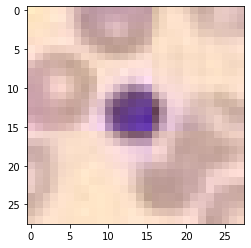

In [9]:
# Displays a random image and the label from training dataset to inspct data.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[index])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

Data processing is applied to the dataset to auguement data when the size of the data set is small. The advantages of data augmentation are as follows:

  

*   It reduces the cost of collection of data.
*   It reduces data overfitting.
*   It creates variability and flexibility in data models.



In the model applied we implement horizontal flipping,vertical flipping, 
featurewise Pixel Normalization: scale pixel values to the range 0-1.
featurewise Pixel Centering: scale pixel values to have a zero mean.

featurewise here means per dataset

The fit function is then invoked to calculate the image statistics in the data generator function and store the value in memory
    


In [10]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    )

In [101]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

The chosen convolution model here consists of an input layer which takes in the shape of the data set (28x28x3). Followed by a convolution layer. A convolution layer transforms the input image in order to extract features from it. The layer was invoked from keras with with the following arguments



*   Filters : determinesthe number of output filters in the convolution 

*   Kernel size : A tuple/list specifying the height and width of the 2D convolution window
*   Activation : Specifies the activation function of the convolution layer

Since we havent defined the model as sequential we specify how this model is connected at the end of the initiation.

After convolution layer we have the pooling layer. Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map. the pooling layer has  a pool size of 2,2 over which the max value is considered

we have two blocks of conv layer followed by maxpool layer. Then we flatten the dataset. Flattening is used to convert all the resultant 2-Dimensional arrays from pooled feature maps into a single long continuous linear vector. The flattened matrix is fed as input to the fully connected layer to classify the image. The final layer applies a softmax activation to classify the data and has 8 output nodes.



In [12]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0     

## Model Training
This is where we define the training options and then train the model.


Stochastic gradient descent is an iterative learning algorithm that uses a 

*   Stochastic gradient descent is an iterative learning algorithm that uses a training dataset to update a model.

*   The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
*   The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

*   learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.


*   Loss functions measure how far an estimated value is from its true value
Categorical crossentropy is a loss function that is used in multi-class classification tasks. It is used to classify when examples only belong to one out of many possible categories.

*   Metrics are used to evaluate the model. Accuracy Calculates how often predictions equal labels. 
*   Shuffle is set to false so that no shuffling of data takes places when augumenting data to preserve index












In [13]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [14]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE,shuffle=False), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE,shuffle=False),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
186/186 [==============================] - 10s 48ms/step - loss: 1.9666 - accuracy: 0.2621 - val_loss: 1.8071 - val_accuracy: 0.3843
Epoch 2/10
186/186 [==============================] - 9s 47ms/step - loss: 1.6863 - accuracy: 0.4566 - val_loss: 1.5738 - val_accuracy: 0.4690
Epoch 3/10
186/186 [==============================] - 9s 48ms/step - loss: 1.4790 - accuracy: 0.5005 - val_loss: 1.3941 - val_accuracy: 0.5175
Epoch 4/10
186/186 [==============================] - 9s 49ms/step - loss: 1.3364 - accuracy: 0.5453 - val_loss: 1.2615 - val_accuracy: 0.5789
Epoch 5/10
186/186 [==============================] - 9s 48ms/step - loss: 1.2256 - accuracy: 0.5836 - val_loss: 1.1852 - val_accuracy: 0.5905
Epoch 6/10
186/186 [==============================] - 9s 48ms/step - loss: 1.1455 - accuracy: 0.6101 - val_loss: 1.1126 - val_accuracy: 0.6221
Epoch 7/10
186/186 [==============================] - 9s 48ms/step - loss: 1.0806 - accuracy: 0.6304 - val_loss: 1.0421 - val_accuracy: 0.640

## Plot Learning Curves
This is where we visualise the training of the model.

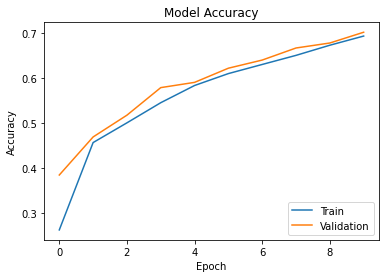

In [16]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

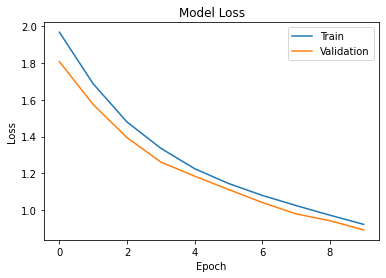

In [17]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate data

We evaulate data using the model.evaluate function and passing the test data and the corresponding test labels. we use the model train to predict values based on test data and compare it to test lables to predict accuracy.

In [108]:
model.evaluate(data_generator.flow(test_x, to_categorical(test_y),batch_size=BATCH_SIZE,shuffle=False))


54/54 [==============================] - 1s 16ms/step - loss: 0.9046 - accuracy: 0.6887


[0.9046130776405334, 0.6886875033378601]

In [111]:
# predict values using the augumented test data set
ypred=model.predict(data_generator.flow(test_x,batch_size=BATCH_SIZE,shuffle=False))
# convert probability distribution to index of the class
ypred1 = np.argmax(ypred, 1)
ypred1

array([3, 1, 1, ..., 1, 1, 2])

In [110]:
# convert to categorical
testy1=to_categorical(test_y,num_classes=8)
# identify the index of the class
testy2= np.argmax(testy1, 1)
testy2

array([3, 0, 1, ..., 3, 1, 7])

In [115]:
# calculate the precision, recall and F1 score
print(classification_report(testy2, ypred1,target_names=targetnames))

                                                                     precision    recall  f1-score   support

                                                           basophil       0.48      0.17      0.25       244
                                                         eosinophil       0.64      0.89      0.75       624
                                                       erythroblast       0.80      0.73      0.77       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.55      0.42      0.48       579
                                                         lymphocyte       0.73      0.66      0.69       243
                                                           monocyte       0.42      0.40      0.41       284
                                                         neutrophil       0.74      0.86      0.80       666
                                                           platelet       0.98      0.98      0.98       470

                 

# Inference

In this exercise we classify an Multi-class(8) dataset with a Convolution neural network. our model consist of an input layer which takes 28x28x3 as input , 2 convolution layers, 2 maxpool layers, A flatten and finaly an output layer. The total number of trainable parameters is 16552. The proposed model has an accuracy of 68%  with the augumented test dataset. This in line with the predicted values in the classification report. The testdataset is augumented because we need the test set to be similar to the training set due to image processing like standardization,centering,cropping etc. The main advantage of CNN compared to its predecessors is that it automatically detects the important features without any human supervision.

F1 score is a combined metric defined as product of precision*recall over the sum of precision and recall. Precision is defined as true positive over sum of true positive and false positive, Recall is definied as the true positive over sum of true positive and false negative. Precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results. Our ideal value is getting a 1 on F1 score meaning 1 on both precision as well as recall.
From the classification report we can see that platelets has a score of 0.98 meaning its being classified correctly and repeatedly.basophil has the lowest F1 score and has a recal of 0.17 meaning there are lot of false negatives during classification. 